In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
# utility functions
def read_text(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return f.read()


def create_vocab(text):
    chars = sorted(list(set(text)))
    stoi = {ch: i for i, ch in enumerate(chars)}
    itos = {i: ch for i, ch in enumerate(chars)}
    return chars, stoi, itos


def encode_string(s, stoi):
    return [stoi[c] for c in s]


def decode_indices(l, itos):
    return "".join([itos[i] for i in l])


def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Evaluation Interval")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.show()

In [5]:
# hyperparameters
class Config:
    batch_size = 128  # how many independent sequences will we process in parallel?
    block_size = 256  # what is the maximum context length for predictions?
    max_iters = 5000
    eval_interval = 100
    learning_rate = 3e-4
    device = "cuda" if torch.cuda.is_available() else "cpu"
    eval_iters = 100
    n_embd = 384
    n_head = 6
    n_layer = 8
    dropout = 0.2  
    
    
# set random seed for reproducibility
torch.manual_seed(1337)

In [6]:
class Dataset:
    def __init__(self, text, block_size, train_split=0.9):
        self.data = torch.tensor(encode_string(text, stoi), dtype=torch.long)
        n = int(train_split * len(self.data))
        self.train_data = self.data[:n]
        self.val_data = self.data[n:]
        self.block_size = block_size

    def get_batch(self, split):
        data = self.train_data if split == "train" else self.val_data
        ix = torch.randint(len(data) - self.block_size, (Config.batch_size,))
        x = torch.stack([data[i : i + Config.block_size] for i in ix])
        y = torch.stack([data[i + 1 : i + Config.block_size + 1] for i in ix])
        x, y = x.to(Config.device), y.to(Config.device)
        return x, y

In [7]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(Config.n_embd, head_size, bias=False)
        self.query = nn.Linear(Config.n_embd, head_size, bias=False)
        self.value = nn.Linear(Config.n_embd, head_size, bias=False)
        self.register_buffer(
            "tril", torch.tril(torch.ones(Config.block_size, Config.block_size))
        )
        self.dropout = nn.Dropout(Config.dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2, -1) * k.shape[-1] ** -0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf"))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, Config.n_embd)
        self.dropout = nn.Dropout(Config.dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [9]:
class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(Config.dropout),
        )

    def forward(self, x):
        return self.net(x)

In [10]:
class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [11]:
class Transformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, Config.n_embd)
        self.position_embedding_table = nn.Embedding(Config.block_size, Config.n_embd)
        self.blocks = nn.Sequential(
            *[Block(Config.n_embd, n_head=Config.n_head) for _ in range(Config.n_layer)]
        )
        self.ln_f = nn.LayerNorm(Config.n_embd)
        self.lm_head = nn.Linear(Config.n_embd, vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=Config.device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -Config.block_size :]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx


def estimate_loss(model, data_loader):
    model.eval()
    losses = {"train": [], "val": []}
    with torch.no_grad():
        for split in ["train", "val"]:
            for _ in range(Config.eval_iters):
                x, y = data_loader.get_batch(split)
                _, loss = model(x, y)
                losses[split].append(loss.item())
    model.train()
    return {split: torch.tensor(losses[split]).mean().item() for split in losses}


def save_model(model, path):
    torch.save(model.state_dict(), path)

In [12]:
text = read_text("cleaned_text.txt")
chars, stoi, itos = create_vocab(text)
vocab_size = len(chars)
data_loader = Dataset(text, Config.block_size)

In [13]:
# Initialize model and optimizer
model = Transformer().to(Config.device)
optimizer = torch.optim.AdamW(model.parameters(), lr=Config.learning_rate)
print(f"{sum(p.numel() for p in model.parameters())/1e6:.2f}M parameters")

14.53M parameters


In [12]:
# Lists to store losses for plotting
train_losses = []
val_losses = []

# Training loop
for iter in tqdm(range(Config.max_iters)):
    if iter % Config.eval_interval == 0 or iter == Config.max_iters - 1:
        losses = estimate_loss(model, data_loader)
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    xb, yb = data_loader.get_batch("train")
    logits, loss = model(xb, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


  0%|          | 0/5000 [00:00<?, ?it/s]

step 0: train loss 5.7680, val loss 5.7596


  2%|▏         | 100/5000 [01:12<37:11,  2.20it/s] 

step 100: train loss 2.5638, val loss 2.4934


  4%|▍         | 200/5000 [02:24<34:30,  2.32it/s]   

step 200: train loss 2.4814, val loss 2.4271


  6%|▌         | 300/5000 [03:35<34:17,  2.28it/s]   

step 300: train loss 2.3710, val loss 2.3257


  8%|▊         | 400/5000 [04:47<33:12,  2.31it/s]   

step 400: train loss 2.0362, val loss 1.9910


 10%|█         | 500/5000 [05:59<33:32,  2.24it/s]   

step 500: train loss 1.8315, val loss 1.7966


 12%|█▏        | 600/5000 [07:10<31:49,  2.30it/s]   

step 600: train loss 1.6935, val loss 1.6737


 14%|█▍        | 700/5000 [08:22<31:47,  2.25it/s]   

step 700: train loss 1.5907, val loss 1.5816


 16%|█▌        | 800/5000 [09:35<32:59,  2.12it/s]   

step 800: train loss 1.5194, val loss 1.5168


 18%|█▊        | 900/5000 [10:46<29:23,  2.32it/s]   

step 900: train loss 1.4723, val loss 1.4744


 20%|██        | 1000/5000 [11:58<29:06,  2.29it/s]  

step 1000: train loss 1.4289, val loss 1.4370


 22%|██▏       | 1100/5000 [13:10<28:19,  2.29it/s]  

step 1100: train loss 1.3976, val loss 1.4175


 24%|██▍       | 1200/5000 [14:21<27:37,  2.29it/s]  

step 1200: train loss 1.3723, val loss 1.3883


 26%|██▌       | 1300/5000 [15:33<26:52,  2.29it/s]  

step 1300: train loss 1.3479, val loss 1.3691


 28%|██▊       | 1400/5000 [16:44<26:08,  2.29it/s]  

step 1400: train loss 1.3308, val loss 1.3509


 30%|███       | 1500/5000 [17:56<25:18,  2.31it/s]  

step 1500: train loss 1.3132, val loss 1.3351


 32%|███▏      | 1600/5000 [19:07<24:42,  2.29it/s]  

step 1600: train loss 1.3019, val loss 1.3278


 34%|███▍      | 1700/5000 [20:19<24:00,  2.29it/s]  

step 1700: train loss 1.2898, val loss 1.3147


 36%|███▌      | 1800/5000 [21:32<23:42,  2.25it/s]  

step 1800: train loss 1.2777, val loss 1.3101


 38%|███▊      | 1900/5000 [22:44<22:34,  2.29it/s]  

step 1900: train loss 1.2675, val loss 1.2961


 40%|████      | 2000/5000 [23:56<22:22,  2.24it/s]  

step 2000: train loss 1.2536, val loss 1.2865


 42%|████▏     | 2100/5000 [25:08<21:05,  2.29it/s]  

step 2100: train loss 1.2460, val loss 1.2796


 44%|████▍     | 2200/5000 [26:20<20:27,  2.28it/s]  

step 2200: train loss 1.2345, val loss 1.2723


 46%|████▌     | 2300/5000 [27:32<19:36,  2.29it/s]  

step 2300: train loss 1.2305, val loss 1.2698


 48%|████▊     | 2400/5000 [28:43<18:37,  2.33it/s]  

step 2400: train loss 1.2218, val loss 1.2598


 50%|█████     | 2500/5000 [29:55<18:54,  2.20it/s]  

step 2500: train loss 1.2157, val loss 1.2559


 52%|█████▏    | 2600/5000 [31:07<17:28,  2.29it/s]  

step 2600: train loss 1.2125, val loss 1.2543


 54%|█████▍    | 2700/5000 [32:19<16:43,  2.29it/s]  

step 2700: train loss 1.2024, val loss 1.2484


 56%|█████▌    | 2800/5000 [33:30<15:59,  2.29it/s]  

step 2800: train loss 1.2026, val loss 1.2495


 58%|█████▊    | 2900/5000 [34:42<15:17,  2.29it/s]  

step 2900: train loss 1.1999, val loss 1.2442


 60%|██████    | 3000/5000 [35:53<14:33,  2.29it/s]  

step 3000: train loss 1.1909, val loss 1.2395


 62%|██████▏   | 3100/5000 [37:05<13:44,  2.30it/s]  

step 3100: train loss 1.1861, val loss 1.2331


 64%|██████▍   | 3200/5000 [38:16<13:03,  2.30it/s]  

step 3200: train loss 1.1878, val loss 1.2341


 66%|██████▌   | 3300/5000 [39:28<12:19,  2.30it/s]  

step 3300: train loss 1.1815, val loss 1.2312


 68%|██████▊   | 3400/5000 [40:39<11:30,  2.32it/s]  

step 3400: train loss 1.1733, val loss 1.2234


 70%|███████   | 3500/5000 [41:50<10:54,  2.29it/s]  

step 3500: train loss 1.1685, val loss 1.2216


 72%|███████▏  | 3600/5000 [43:02<10:08,  2.30it/s]  

step 3600: train loss 1.1641, val loss 1.2151


 74%|███████▍  | 3700/5000 [44:13<09:26,  2.29it/s]  

step 3700: train loss 1.1611, val loss 1.2197


 76%|███████▌  | 3800/5000 [45:24<08:42,  2.30it/s]  

step 3800: train loss 1.1623, val loss 1.2199


 78%|███████▊  | 3900/5000 [46:35<07:58,  2.30it/s]  

step 3900: train loss 1.1532, val loss 1.2131


 80%|████████  | 4000/5000 [47:47<07:12,  2.31it/s]  

step 4000: train loss 1.1517, val loss 1.2097


 82%|████████▏ | 4100/5000 [48:57<06:27,  2.33it/s]  

step 4100: train loss 1.1494, val loss 1.2064


 84%|████████▍ | 4200/5000 [50:09<05:46,  2.31it/s]  

step 4200: train loss 1.1459, val loss 1.2018


 86%|████████▌ | 4300/5000 [51:22<05:08,  2.27it/s]  

step 4300: train loss 1.1407, val loss 1.1993


 88%|████████▊ | 4400/5000 [52:34<04:23,  2.28it/s]  

step 4400: train loss 1.1401, val loss 1.2015


 90%|█████████ | 4500/5000 [53:47<03:41,  2.26it/s]  

step 4500: train loss 1.1393, val loss 1.1962


 92%|█████████▏| 4600/5000 [54:59<03:04,  2.17it/s]  

step 4600: train loss 1.1351, val loss 1.1964


 94%|█████████▍| 4700/5000 [56:11<02:11,  2.28it/s]

step 4700: train loss 1.1337, val loss 1.1923


 96%|█████████▌| 4800/5000 [57:21<01:25,  2.33it/s]

step 4800: train loss 1.1323, val loss 1.1936


 98%|█████████▊| 4900/5000 [58:32<00:43,  2.32it/s]

step 4900: train loss 1.1325, val loss 1.1932


100%|█████████▉| 4999/5000 [59:41<00:00,  2.32it/s]

step 4999: train loss 1.1276, val loss 1.1890


100%|██████████| 5000/5000 [1:00:09<00:00,  1.39it/s]


In [13]:
# Save the model
save_model(model, "transformer.pth")

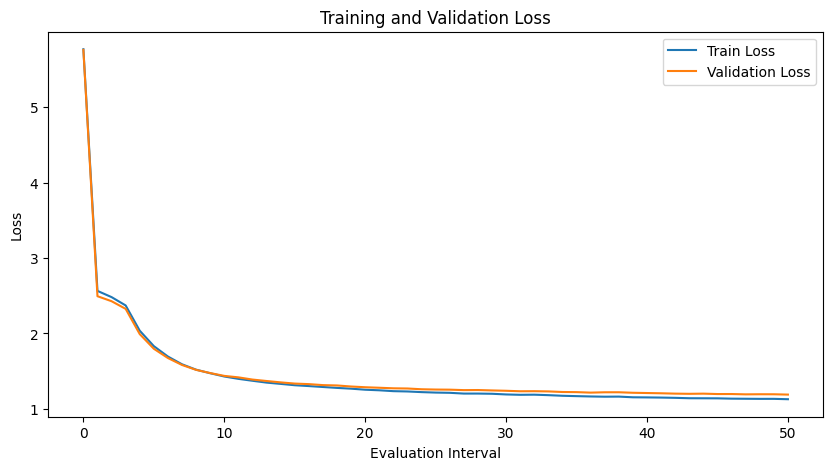

In [14]:
# Plot the losses
plot_losses(train_losses, val_losses)

In [14]:
# Generate text
def encode_input_string(s):
    return torch.tensor(encode_string(s, stoi), dtype=torch.long).unsqueeze(0).to(Config.device)

def generate_from_input(input_str, max_new_tokens=100):
    input_tensor = encode_input_string(input_str)
    generated = model.generate(input_tensor, max_new_tokens=max_new_tokens)
    return decode_indices(generated[0].tolist(), itos)

In [15]:
# load weights
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.to(Config.device)

load_model(model, "transformer.pth")    

In [21]:
benchmark_data = [
    ("Detective John entered the dimly lit room, only to find a pool of blood next to ", 50),
    ("The suspect had a solid alibi, but something in his eyes told the inspector that ", 100),
    ("She never expected the secret message hidden in the old locket would lead her to ", 60),
    ("As the clock struck midnight, the eerie silence was broken by the sound of ", 200),
    ("The missing pages from the diary hinted at a conspiracy that went all the way to ", 55),
    ("With every step in the abandoned warehouse, Mark could feel someone watching him from ", 45),
    ("The coded note left at the crime scene was the key to unraveling the mystery of ", 100),
    ("Just as she was about to give up, a mysterious figure emerged from the shadows and ", 60),
    ("The old detective had seen many cases, but nothing as chilling as the one involving ", 150),
    ("Every clue pointed to the butler, but the real mastermind behind the crimes was ", 50),
]

for prompt, max_new_tokens in benchmark_data:
    print(f"\"{generate_from_input(prompt, max_new_tokens=max_new_tokens)}\"\n")


"Detective John entered the dimly lit room, only to find a pool of blood next to the
room, repeating his direction, he had no amuse"

"The suspect had a solid alibi, but something in his eyes told the inspector that had
accepted him split for my protection. Every proper her ladyship was rome
thickening and vender I"

"She never expected the secret message hidden in the old locket would lead her to again.
By no resurrant half anything more so in the country "

"As the clock struck midnight, the eerie silence was broken by the sound of the
duty, and had scound made by a place upon the patient crying all the
squires were uttered... upon baptizing between trypinolids over the
steel, and the miracle seemed to beat the summer, as and ca"

"The missing pages from the diary hinted at a conspiracy that went all the way to him
and was him. After though it was deserted ill fatig"

"With every step in the abandoned warehouse, Mark could feel someone watching him from the
office, and now as a matte